In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
inspector = inspect(engine)

In [6]:
inspector.get_table_names()

['measurement', 'station']

In [7]:
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [8]:
columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [9]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [10]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [11]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [12]:
# Create our session (link) from Python to the DB
session = Session(engine)
connect = engine.connect()

In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
# Perform a query to retrieve the data and precipitation scores
# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date
precip_df =  pd.read_sql_query("SELECT measurement.date, measurement.prcp FROM measurement WHERE date >= '2016-08-23' AND date <= '2017-08-23';", connect)
precip_df.set_index('date', inplace=True, )
precip_df.head()


,prcp
date,
2016-08-23,0.00
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00


# Exploratory Climate Analysis

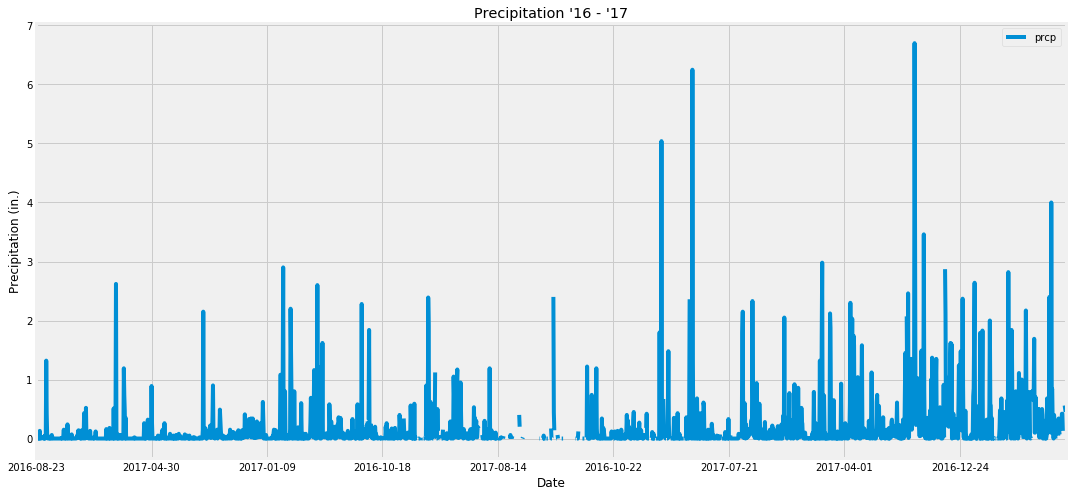

In [14]:
# Use Pandas Plotting with Matplotlib to plot the data

fig, ax = plt.subplots(figsize = (15, 7))
precip_df.plot(ax = ax, x_compat = True)

#set title and labels
ax.set_xlabel('Date')
ax.set_ylabel('Precipitation (in.)')
ax.set_title("Precipitation '16 - '17")
plt.tight_layout()
plt.savefig("C:\\Users\\richn\\Desktop\\climate.png")
plt.show()


In [15]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precip_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [16]:
# Design a query to show how many stations are available in this dataset?
station = pd.read_sql("SELECT count(station) FROM station;", connect)
station

,count(station)
0,9


In [17]:
df = pd.read_sql("SELECT * FROM station;", connect)
df2 = pd.read_sql("SELECT * FROM measurement;",connect)

In [18]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active = pd.read_sql("SELECT count(measurement.id), station.station FROM measurement LEFT JOIN station ON station.station=measurement.station GROUP BY station.station;", connect)
active.set_index('station', inplace=True, )
active.sort_values(by='count(measurement.id)', ascending=False)

,count(measurement.id)
station,
USC00519281,2772
USC00519397,2724
USC00513117,2709
USC00519523,2669
USC00516128,2612
USC00514830,2202
USC00511918,1979
USC00517948,1372
USC00518838,511


In [19]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
active_station = 'USC00519281'

temps = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == active_station).all()
temps

[(54.0, 85.0, 71.66378066378067)]

In [20]:
# Choose the station with the highest number of temperature observations.
temp_results = session.query(Measurement.station, Measurement.tobs).\
    filter(Measurement.station == active_station).\
    filter(Measurement.date >= '2016-08-23', Measurement.date <= '2017-08-23').all()
temp_df = pd.DataFrame(temp_results)
temp_df.set_index('station', inplace=True, )


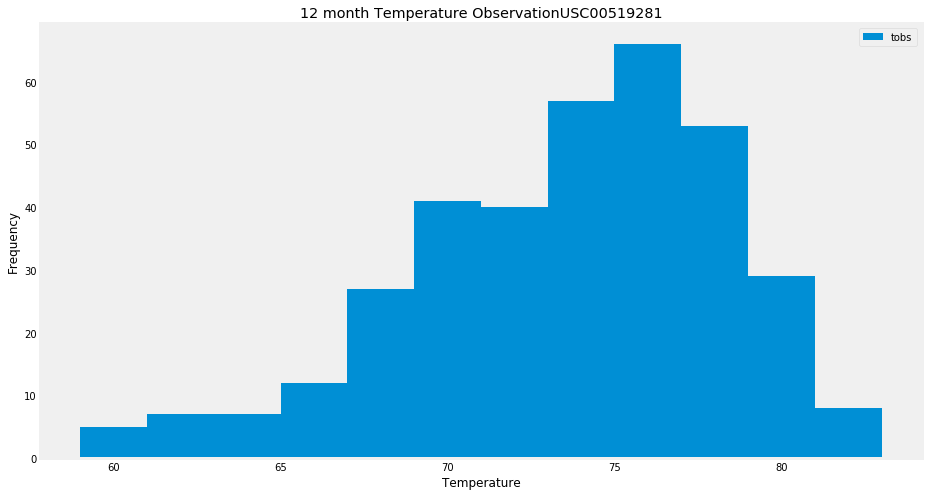

In [21]:
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

temp_df.plot.hist(by='station', bins=12, figsize = (13,7))
plt.grid()
plt.title('12 month Temperature Observation' + active_station)
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.tight_layout()
plt.savefig("C:\\Users\\richn\\Desktop\\temp_observation.png")
plt.show()


In [22]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [23]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip = calc_temps('2017-08-18', '2017-08-23')
trip

[(71.0, 79.31818181818181, 85.0)]

In [24]:
tripdf = pd.DataFrame(trip, columns=['Min Temp', 'Max Temp', 'Avg Temp'])

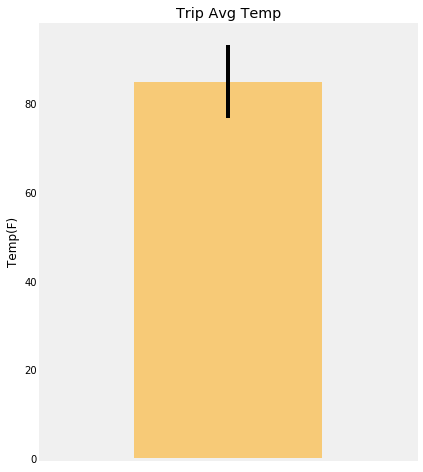

In [25]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
avg_temp = tripdf['Avg Temp']
min_max_temp = tripdf.iloc[0]['Max Temp'] - tripdf.iloc[0]['Min Temp']
avg_temp.plot(kind='bar', yerr=min_max_temp, figsize=(6,8), alpha=0.5, color='orange')
plt.title('Trip Avg Temp')
plt.ylabel('Temp(F)')
plt.xticks([])
plt.grid()
plt.savefig("C:\\Users\\richn\\Desktop\\trip_temp.png")
plt.show()

In [26]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

rain_total = session.query(Station.station, Station.latitude, Station.longitude, Station.elevation, func.avg(Measurement.prcp)).\
    filter(Measurement.station == Station.station).\
    filter(Measurement.date >= '2016-08-18', Measurement.date <= '2016-08-23').group_by(Station.station).\
    order_by(func.avg(Measurement.prcp).desc()).all()
rain_total

[('USC00516128', 21.3331, -157.8025, 152.4, 0.9483333333333334),
 ('USC00519281', 21.45167, -157.84888999999998, 32.9, 0.7716666666666666),
 ('USC00513117', 21.4234, -157.8015, 14.6, 0.2633333333333333),
 ('USC00519523', 21.33556, -157.71139, 19.5, 0.13833333333333334),
 ('USC00519397', 21.2716, -157.8168, 3.0, 0.09333333333333334),
 ('USC00514830', 21.5213, -157.8374, 7.0, 0.0325),
 ('USC00517948', 21.3934, -157.9751, 11.9, 0.0)]

## Optional Challenge Assignment

In [27]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals('01-01')

[(62.0, 69.15384615384616, 77.0)]

In [37]:
# calculate the daily normals for your trip
def daily_normals(date):
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()

daily_normals("08-18")
# push each tuple of calculations into a list called `normals`
normals = list(np.ravel(daily_normals))
normals
# Set the start and end date of the trip
start_trip = ('2015-08-18')
end_trip = ('2015-08-23')
# Use the start and end date to create a range of dates
trip_dates = pd.date_range(start_trip, end_trip)
# Stip off the year and save a list of %m-%d strings
trips = trip_dates.strftime('%m-%d')
# Loop through the list of %m-%d strings and calculate the normals for each date
daily_norms = []

for trip_date in trips:
    
    daily_norms.append(*daily_normals(trip_date))
    
    
#daily_norms

In [43]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
daily_normsdf = pd.DataFrame(daily_norms, columns = ['Trip_min', 'Trip_avg', 'Trip_max'])
daily_normsdf['Date'] = trips
daily_normsdf.set_index('Date', inplace=True, )
daily_normsdf

,Trip_min,Trip_avg,Trip_max
Date,,,
08-18,70.0,76.923077,84.0
08-19,69.0,75.946429,85.0
08-20,68.0,76.452830,82.0
08-21,67.0,76.400000,83.0
08-22,69.0,76.471698,84.0
08-23,67.0,76.692308,87.0


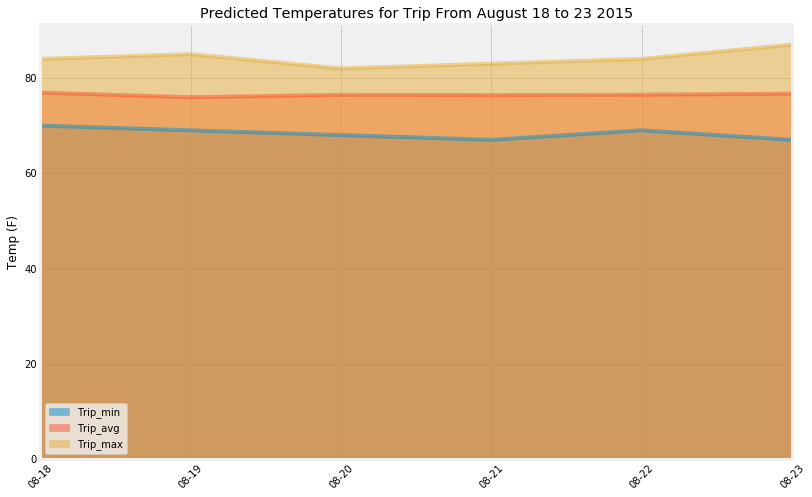

In [46]:
# Plot the daily normals as an area plot with `stacked=False`
colors = ['blue', 'orange', 'palegreen']

#make an area plot for the predicted temps
daily_normsdf.plot(kind='area', figsize=(12, 8), stacked=False, x_compat=True, title='Predicted Temperatures for Trip From August 18 to 23 2015', rot=45)

#make the labels
plt.xlabel('')
plt.ylabel('Temp (F)')
plt.savefig("C:\\Users\\richn\\Desktop\\predicted_temp.png")
plt.show()